In [228]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [229]:
np.random.seed(42)

In [230]:
root_path = "/Users/leonardomassaro/Desktop/dataset_books/"

In [231]:
scenes_paths = [root_path + f"scenes/scene_{i}.jpg" for i in range(29)]
model_paths = [root_path + f"models/model_{i}.png" for i in range(22)]

In [232]:

def display_image_grid(images, total_size=(10, 10), ncols=None, show_axes=False):
    num_images = len(images)
    if num_images == 0:
        raise ValueError("The image list is empty.")

    # Auto-determine number of columns and rows
    if ncols is None:
        ncols = math.ceil(math.sqrt(num_images))
    nrows = math.ceil(num_images / ncols)

    # Create figure
    fig, axes = plt.subplots(nrows, ncols, figsize=total_size,
                             constrained_layout=True)

    # Flatten axes array for easy iteration
    if isinstance(axes, plt.Axes):
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_images:
            img = images[i]
            ax.imshow(img, aspect='equal', cmap='gray')  # Preserve each image's aspect ratio
            if not show_axes:
                ax.axis('off')
        else:
            ax.axis('off')  # Hide unused subplots

    plt.show()

In [233]:
def cut_out_borders(image, vertical_percentage:int, horizontal_percentage):
    if vertical_percentage >= 50 or horizontal_percentage >= 50:
        raise Exception("Percentage must be lower than 50%")
    cut_x, cut_y = int((image.shape[0]/100)*horizontal_percentage), int((image.shape[1]/100)*vertical_percentage)
    return image[cut_y:-cut_y-1, cut_x:-cut_x-1 ]

In [234]:
def bilateral_filter_for_models(img):
    return cv2.bilateralFilter(img, d=4, sigmaColor=75, sigmaSpace=75)

In [235]:
def edge_on_rgb(image_rgb, params):
    THRESH1, THRESH2 = params["thresh1_canny"], params["thresh2_canny"]
    D = params["bilat_filter_d"]
    SIGMA_COLOR, SIGMA_SPACE = params["bilat_sigma_col"], params["bilat_sigma_space"]
    bilateral_filtered = cv2.Canny(cv2.bilateralFilter(image_rgb, d=D, sigmaColor=SIGMA_COLOR, sigmaSpace=SIGMA_SPACE), THRESH1, THRESH2)
    return bilateral_filtered

In [236]:
def expand_edges_scenes(edge_image, params):
    if params["expand_edges_isActive"]:
        STRUCT_ELEM_SHAPE = params["structuring_elem_shape"]
        KERNEL = params["kernel_struct_elem"]
        MORPH_MODE = params["morph_mode"]
        kernel = cv2.getStructuringElement(STRUCT_ELEM_SHAPE, KERNEL)
        closed = cv2.morphologyEx(edge_image, MORPH_MODE, kernel)
        return closed
    else:
        return edge_image

In [237]:

def extract_connected_regions(image, points, connectivity=4):
    h, w = image.shape
    tot_mask = image - image
    # Keep track of processed pixels to avoid overlaps
    processed = np.zeros_like(image, dtype=np.uint8)
    for (x, y) in points:
        if x < 0 or y < 0 or x >= w or y >= h:
            print(f"Skipping invalid point {x, y}")
            continue
        target_value = image[y, x]

        # Skip if already processed
        if processed[y, x]:
            continue

        #if it is on the edge do not consider
        if target_value != 0:
            mask = np.zeros((h + 2, w + 2), np.uint8)
            mask[y,x] = 255
        else:
            # Flood fill to get connected region
            mask = np.zeros((h + 2, w + 2), np.uint8)
            _, _, _, rect = cv2.floodFill(
                image.copy(), mask, (x, y),
                newVal=255,
                loDiff=0, upDiff=0,
                flags=connectivity | (255 << 8)
            )

        # Flood-filled mask (remove 1px border added by OpenCV)
        region_mask = (mask[1:-1, 1:-1] > 0).astype(np.uint8)

        # Update processed
        processed = cv2.bitwise_or(processed, region_mask)

        tot_mask = cv2.bitwise_or(tot_mask, region_mask)

    return tot_mask

In [238]:
def get_bounding_box_from_mask(mask):
    mask = (mask > 0).astype(np.uint8)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None

    # Combine all contours to get the overall region
    cnt = np.vstack(contours)

    # Get min-area rectangle
    rect = cv2.minAreaRect(cnt)
    (cx, cy), (w, h), angle = rect
    (cx, cy), (w, h), angle = (cx, cy), (w, h), angle


    # Convert to 4 corner points
    box_points = cv2.boxPoints(rect)
    box_points = np.int64(box_points)

    return box_points, rect

In [239]:
def compute_sift(models, scenes, scenes_grayscale, params):
    SIGMA = params["sift_sigma"]
    OCT_LYRS = params["sift_oct_layers"]
    CONTRAST_THRESH = params["sift_contrast_thresh"]
    EDGE_THRESH = params["sift_edge_thresh"]
    
    sift = cv2.SIFT_create(sigma=SIGMA, nOctaveLayers=OCT_LYRS, contrastThreshold=CONTRAST_THRESH, edgeThreshold=EDGE_THRESH)

    models_kp_des = {}  # dict: idx -> {img, kp, des}
    for i, img in enumerate(models):
        if img is None:
            models_kp_des[i] = {'img': None, 'kp': None, 'des': None}
            continue
        kp, des = sift.detectAndCompute(img, None)
        models_kp_des[i] = {'img': img, 'kp': np.array(kp), 'des': np.array(des)}

    scenes_kp_des = {}  # dict: idx -> {img_color, img_gray, kp, des}
    for i, (img_color, img_gray) in enumerate(zip(scenes, scenes_grayscale)):
        if img_gray is None or img_color is None:
            scenes_kp_des[i] = {'img_color': img_color, 'img_gray': img_gray, 'kp': None, 'des': None}
            continue
        kp_s, des_s = sift.detectAndCompute(img_gray, None)
        scenes_kp_des[i] = {'img_color': img_color, 'img_gray': img_gray, 'kp': np.array(kp_s), 'des': np.array(des_s)}
    
    return models_kp_des, scenes_kp_des

In [240]:
def instance_in_scene(model_kp_des: dict, scene_working: dict, params: dict):
    """Compute one instance using keypoints/descriptors lists (no image masking).
    scene_working is mutable and contains 'kp' (list of cv2.KeyPoint) and 'des' (ndarray of descriptors).
    Returns (dst_corners (4x2), used_train_idx_list) or None."""
  
    LOWES_RATIO = params["detection_lowes_ratio"]
    MIN_MATCH_PERCENT = params["detection_min_match_percent"]
    USAC_ERROR = params["usac_error"]

    # validate
    if model_kp_des.get('des') is None or scene_working.get('des') is None:
        return None
    if len(model_kp_des.get('kp', [])) == 0 or len(scene_working.get('kp', [])) == 0:
        return None

    matcher = cv2.BFMatcher(cv2.NORM_L2)
    matches = matcher.knnMatch(model_kp_des['des'], scene_working['des'], k=2)
    if not matches:
        return None

    # Lowe's ratio test
    good_matches = []
    for m_n in matches:
        if len(m_n) != 2:
            continue
        m, n = m_n
        if m.distance < LOWES_RATIO * n.distance:
            good_matches.append(m)

    if len(good_matches) < MIN_MATCH_PERCENT * len(matches):
        return None

    # model corners (note: model img is grayscale)
    h, w = model_kp_des['img'].shape
    model_corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]])

    # prepare src/dst for homography
    try:
        src_pts = np.float32([model_kp_des['kp'][m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([scene_working['kp'][m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    except Exception:
        return None

    try:
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, USAC_ERROR)
        if M is None:
            return None
    except Exception:
        return None

    dst = cv2.perspectiveTransform(np.array([model_corners]), M)[0] # these are the corners in scene coordinates

    # Check if the found homography is good
    area = int(cv2.contourArea(dst))
    if not cv2.isContourConvex(dst) or area < 20:
        return None

    used_train_idx = [m.trainIdx for m in good_matches]
    # Use all matched points for segmentation (not just strict homography inliers)
    # USAC_ACCURATE filters too aggressively; keep all Lowe's ratio tested points
    raw_dst_pts = dst_pts

    return dst, used_train_idx, raw_dst_pts

In [241]:

def detect_multiple_instances(model_kp_des: dict, scene_kp_des: dict, params: dict, max_instances: int = 10, debug= False):
    """Iteratively find instances removing interior keypoints (shrunk polygon) from working scene kp/des."""
    results = []
    SHRINK_POLY = params.get("shrink_poly", 1)
    
    # working copies: kp as list (mutable), des as ndarray
    working_kp = list(scene_kp_des.get('kp', [])) if scene_kp_des.get('kp') is not None else []
    working_des = scene_kp_des.get('des')
    if working_des is not None:
        working_des = working_des.copy()

    scene_working = {'kp': working_kp, 'des': working_des }
    raw_dst_pts = []
    for i in range(max_instances):
        if debug:
          print(f"Attempt {i+1}: remaining scene keypoints { len( scene_working['kp'] ) }")
          # Plot keypoints before detection
          img_with_kp_before = cv2.drawKeypoints(scene_kp_des['img_color'].copy(), scene_working['kp'], None, color=(0,255,0), flags=0)
          plt.figure(figsize=(10, 6))
          plt.imshow(cv2.cvtColor(img_with_kp_before, cv2.COLOR_BGR2RGB))
          plt.title(f'Attempt {i+1}: Keypoints before detection')
          plt.axis('off')
          plt.show()

        out = instance_in_scene(model_kp_des, scene_working, params)
        if out is None:
            break
        dst, _, _ = out
        

        pts = np.int32(dst)
        x_coords = pts[:, 0]
        y_coords = pts[:, 1]
        x_min, x_max = int(x_coords.min()), int(x_coords.max())
        y_min, y_max = int(y_coords.min()), int(y_coords.max())
        area = int((x_max - x_min) * (y_max - y_min))
        results.append({'corners': pts.tolist(), 'bbox': (x_min, y_min, x_max, y_max), 'area': area})

        # shrink polygon towards centroid to avoid removing border keypoints
        # shrink polygon towards centroid to avoid removing border keypoints
        centroid = pts.mean(axis=0)
        shrunk = centroid + SHRINK_POLY * (pts - centroid)
        shrunk = np.int32(shrunk)

        # collect indices of keypoints inside shrunk polygon to be removed
        remove_idx = []
        for idx, kp in enumerate(scene_working['kp']):
            pt = (float(kp.pt[0]), float(kp.pt[1]))
            if cv2.pointPolygonTest(shrunk, pt, False) >= 0:
                remove_idx.append(idx)
        
        centroid = pts.mean(axis=0)
        shrunk = centroid + 0.77 * (pts - centroid)
        shrunk = np.int32(shrunk)

        # collect indices of keypoints inside shrunk polygon to be included (different shrinking parameter)
        raw_dst = []
        for idx, kp in enumerate(scene_working['kp']):
            pt = (float(kp.pt[0]), float(kp.pt[1]))
            if cv2.pointPolygonTest(shrunk, pt, False) >= 0:
                raw_dst.append(list(kp.pt))

        # remove by descending indices from kp list and descriptor array
        # sort indices in descending order to remove from end
        remove_idx.sort(reverse=True)
        for idx in remove_idx:  # TODO: Is all this code about just removing a list of indexes from array? 
            if 0 <= idx < len(scene_working['kp']):
                scene_working['kp'].pop(idx)
            if scene_working['des'] is not None and 0 <= idx < scene_working['des'].shape[0]:
                scene_working['des'] = np.delete(scene_working['des'], idx, axis=0)

        if debug:
          print(f"Attempt {i+1}: keypoints removed: {len(remove_idx)}")

        raw_dst_pts.append(raw_dst)

    return results, raw_dst_pts

In [242]:
def full_experiment(params: dict = {}, max_instances: int = 10):
    X_CUT = params["x_cut"]
    Y_CUT = params["y_cut"]

    scenes = [cv2.imread(path, cv2.IMREAD_COLOR_BGR) for path in scenes_paths]
    scenes_grayscale = [cv2.cvtColor(scene, cv2.COLOR_BGR2GRAY) for scene in scenes]
    models = [cut_out_borders(cv2.imread(path, cv2.IMREAD_COLOR_BGR), Y_CUT, X_CUT) for path in model_paths]
    models_grayscale = [cv2.cvtColor(model, cv2.COLOR_BGR2GRAY) for model in models]

    models_kp_des, scenes_kp_des = compute_sift(models=models_grayscale, scenes=scenes, scenes_grayscale=scenes_grayscale, params=params)

    all_detection_results = {}
    n_models = len(models_kp_des)
    n_scenes = len(scenes_kp_des)

    model_colors= {}

    for i_scene in range(n_scenes):
        sc = scenes_kp_des.get(i_scene)
        if sc is None or sc.get('img_gray') is None:
            continue
        img_color_orig = sc['img_color']
        img_color = img_color_orig.copy()
        img_gray = sc['img_gray'].copy()
        # For per-scene visualization we keep a separate working copy of the gray image for detection masking
        working_gray_for_models = img_gray.copy()
        scene_results = {}

        # Run all models on this scene and draw boxes with distinct colors
        print(f'\nScene {i_scene}:') # Print scene number
        instance_counts = [] # List to store instance counts for this scene

        for i_model in range(n_models):
            mdl = models_kp_des.get(i_model)
            if mdl is None or mdl.get('img') is None:
                continue
            # Pass the individual scene data to detect_multiple_instances
            instances, _ = detect_multiple_instances(mdl, sc, params, max_instances)
            scene_results[i_model] = instances
            all_detection_results[(i_model, i_scene)] = instances
            if len(instances) > 0: # Only add to list if instances are found
                instance_counts.append(f'Model {i_model}: {len(instances)} instance(s)') # Add instance count to the list
            # draw instances for this model with its color
            blue = (255,0,0)
            green =(0,255,0)
            for inst in instances:
                x_min, y_min, x_max, y_max = inst['bbox']
                # polygon (exact corners)
                pts = np.array(inst['corners'], dtype=np.int32)
                cv2.polylines(img_color, [pts], isClosed=True, color=blue, thickness=3)
                cv2.rectangle(img_color, (x_min, y_min), (x_max, y_max), color=green, thickness=1)
                # Put model id near the box
                cv2.putText(img_color, f'M{ i_model }', (x_min, max(y_min-6,0)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, blue, 1, cv2.LINE_AA)
        # After drawing all models for this scene, show a combined image
        img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(7,5))
        plt.imshow(img_rgb)
        plt.title(f'Scene {i_scene}')
        plt.axis('off')
        plt.show()
        # Print instance counts for all models in this scene on one line
        print(' | '.join(instance_counts))
    return all_detection_results,

In [243]:
params = {
    "thresh1_canny": 10,
    "thresh2_canny": 30,
    "bilat_filter_d": 4,
    "bilat_sigma_col": 75,
    "bilat_sigma_space": 75,
    "expand_edges_isActive": True,
    "structuring_elem_shape": cv2.MORPH_RECT,
    "kernel_struct_elem": (3,3),
    "morph_mode": cv2.MORPH_CLOSE,
    "connectivity_direction": 4,
    "sift_sigma": 0.5,
    "sift_oct_layers": 5,
    "sift_contrast_thresh": 0.04,
    "sift_edge_thresh": 10,
    "detection_lowes_ratio": 0.71,
    "detection_min_match_percent": 0.05,
    "usac_error": 3,
    "x_cut": 0,
    "y_cut":0,
    "shrink_poly": 1
}

In [244]:
#results = full_experiment(params=params, max_instances=10)

In [245]:
def object_segmentation(scene, destination_pts, params):
    REGION_CONNECTIVITY = params["connectivity_direction"]
    destination_pts = np.array(destination_pts, dtype=np.int32).reshape(-1,2)
    region = extract_connected_regions(expand_edges_scenes(edge_on_rgb(scene, params), params), destination_pts, REGION_CONNECTIVITY)
    display_image_grid([region], total_size=(3,3))
    bbox, _ = get_bounding_box_from_mask(region)

    final = cv2.drawContours(scene.copy(), [bbox], 0, (0, 255, 0), 2)
    for p in destination_pts:
        final = cv2.drawMarker(final, p, (255,0,0))
    return final, bbox

In [246]:
def alternative_experiment(params: dict = {}, max_instances: int = 10):
    X_CUT = params["x_cut"]
    Y_CUT = params["y_cut"]

    scenes = [cv2.imread(path, cv2.IMREAD_COLOR_BGR) for path in scenes_paths]
    scenes_grayscale = [cv2.cvtColor(scene, cv2.COLOR_BGR2GRAY) for scene in scenes]
    models = [cut_out_borders(cv2.imread(path, cv2.IMREAD_COLOR_BGR), Y_CUT, X_CUT) for path in model_paths]
    models_grayscale = [cv2.cvtColor(model, cv2.COLOR_BGR2GRAY) for model in models]

    models_bilateral = [cv2.bilateralFilter(img, d=3, sigmaColor=65, sigmaSpace=85) for img in models_grayscale]
    scenes_bilateral = [cv2.bilateralFilter(img, d=3, sigmaColor=65, sigmaSpace=85) for img in scenes_grayscale]

    models_kp_des, scenes_kp_des = compute_sift(models=models_bilateral, scenes=scenes, scenes_grayscale=scenes_bilateral, params=params)

    all_detection_results = {}
    n_models = len(models_kp_des)
    n_scenes = len(scenes_kp_des)

    for i_scene in range(n_scenes):
        sc = scenes_kp_des.get(i_scene)
        if sc is None or sc.get('img_gray') is None:
            continue
        img_color_orig = sc['img_color']
        img_color = img_color_orig.copy()
        img_gray = sc['img_gray'].copy()
        # For per-scene visualization we keep a separate working copy of the gray image for detection masking
        working_gray_for_models = img_gray.copy()
        scene_results = {}

        # Run all models on this scene and draw boxes with distinct colors
        print(f'\nScene {i_scene}:') # Print scene number
        instance_counts = [] # List to store instance counts for this scene

        for i_model in range(n_models):
            mdl = models_kp_des.get(i_model)
            if mdl is None or mdl.get('img') is None:
                continue
            # Pass the individual scene data to detect_multiple_instances
            instances, raw_dst_pts = detect_multiple_instances(mdl, sc, params, max_instances)
            bboxes = []
            for dst_pts in raw_dst_pts:
                marked_img, bbox= object_segmentation(scene=scenes[i_scene], destination_pts=dst_pts, params=params)
                bboxes.append(bbox)
            scene_results[i_model] = instances
            all_detection_results[(i_model, i_scene)] = instances
            if len(instances) > 0: # Only add to list if instances are found
              instance_counts.append(f'Model {i_model}: {len(instances)} instance(s)') # Add instance count to the list
            for idx in range(len(instances)):
                cv2.drawContours(img_color, [bboxes[idx]], 0, (0, 255, 0), 2)
        # After drawing all models for this scene, show a combined image
        img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(7,5))
        plt.imshow(img_rgb)
        plt.title(f'Scene {i_scene}')
        plt.axis('off')
        plt.show()
        # Print instance counts for all models in this scene on one line
        print(' | '.join(instance_counts))
    return all_detection_results,

In [247]:
params2 = {
    "thresh1_canny": 10,
    "thresh2_canny": 20,
    "bilat_filter_d": 0,
    "bilat_sigma_col": 30,
    "bilat_sigma_space": 35,
    "expand_edges_isActive": True,
    "structuring_elem_shape": cv2.MORPH_RECT,
    "kernel_struct_elem": (5,5),
    "morph_mode": cv2.MORPH_CLOSE,
    "connectivity_direction": 4,
    "sift_sigma": 0.46,
    "sift_oct_layers": 4,
    "sift_contrast_thresh": 0.05,
    "sift_edge_thresh": 13,
    "detection_lowes_ratio": 0.71,
    "detection_min_match_percent": 0.05,
    "usac_error": 3,
    "x_cut": 0.12,
    "y_cut":0.08,
    "shrink_poly": 0.92
}


Scene 0:


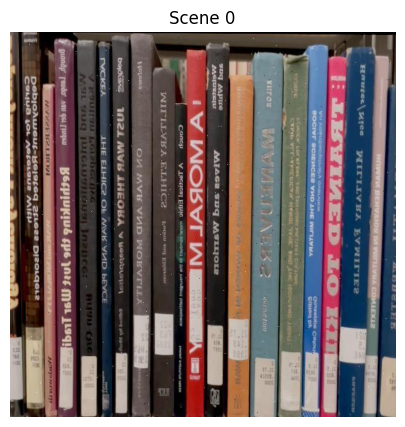



Scene 1:


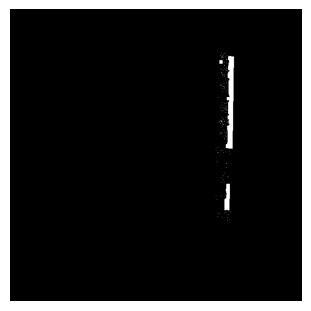

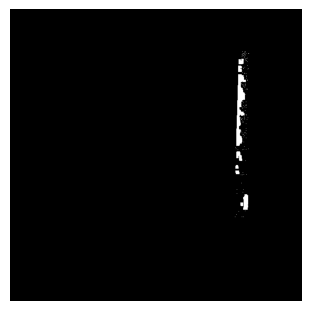

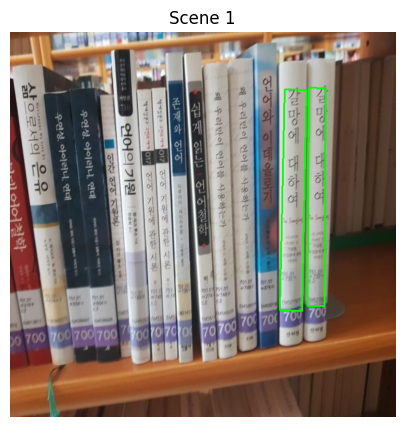

Model 18: 2 instance(s)

Scene 2:


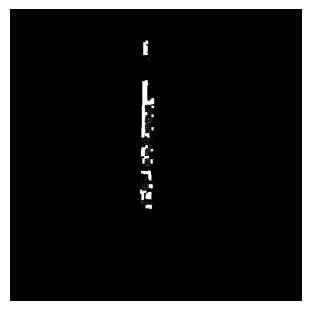

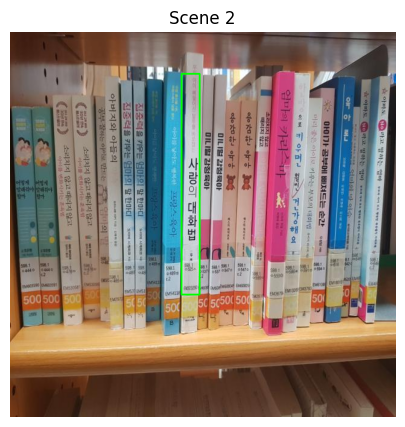

Model 17: 1 instance(s)

Scene 3:


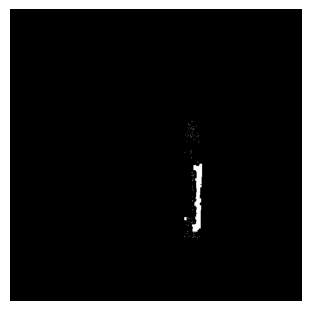

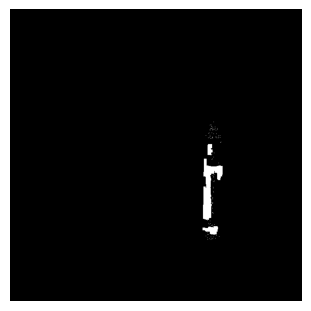

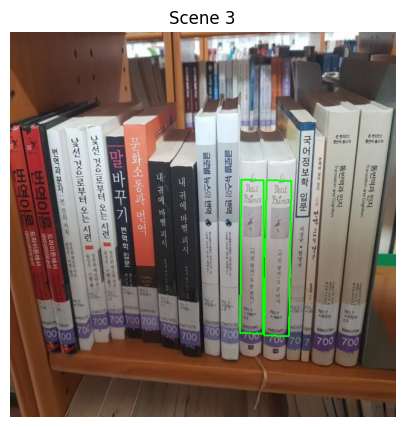

Model 16: 2 instance(s)

Scene 4:


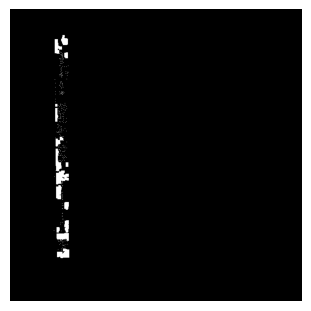

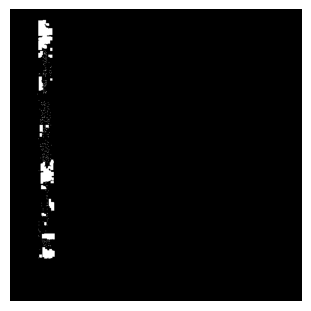

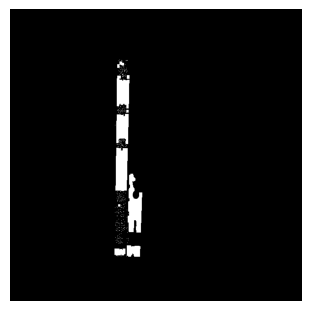

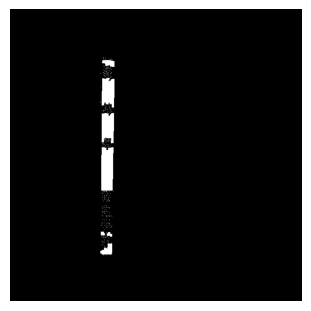

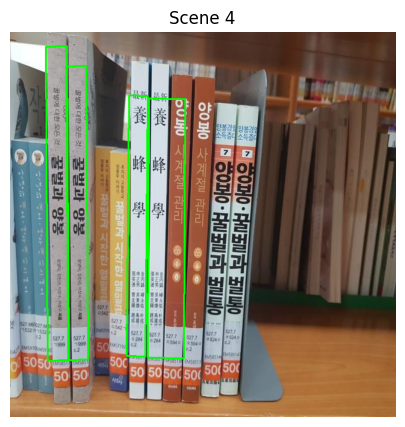

Model 14: 2 instance(s) | Model 15: 2 instance(s)

Scene 5:


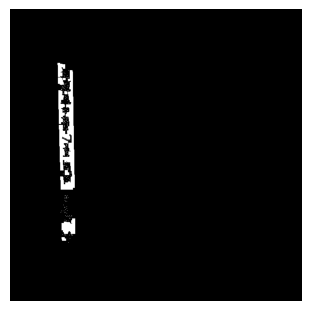

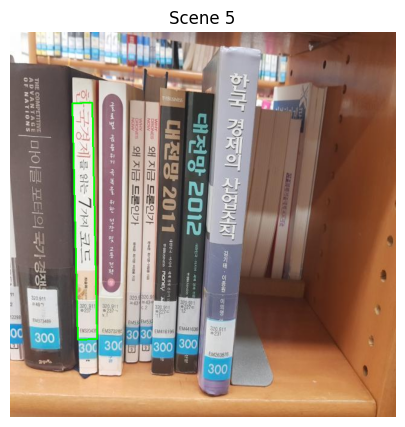

Model 13: 1 instance(s)

Scene 6:


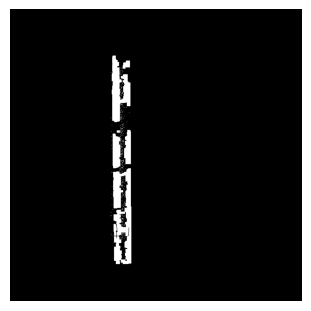

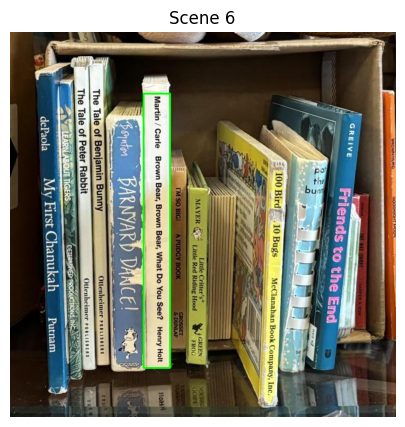

Model 21: 1 instance(s)

Scene 7:


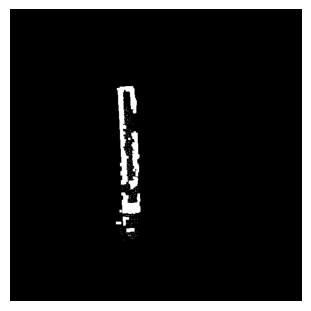

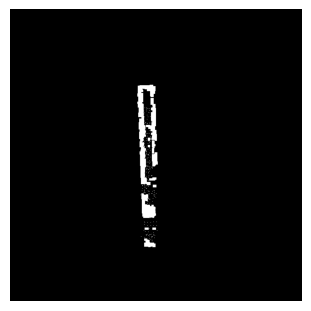

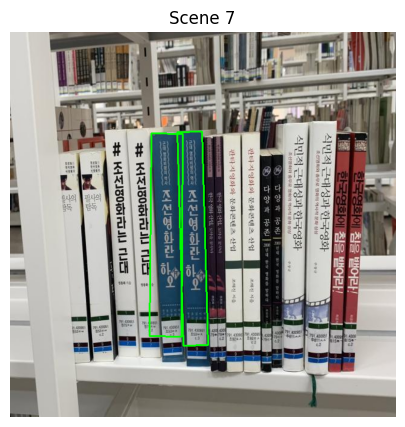

Model 20: 2 instance(s)

Scene 8:


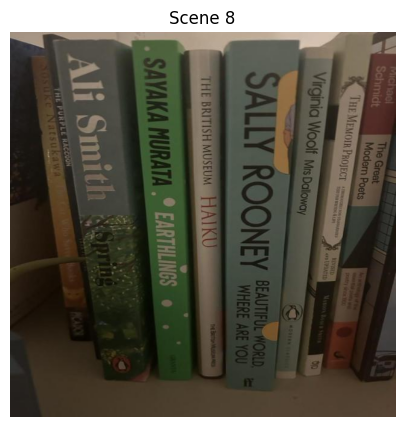



Scene 9:


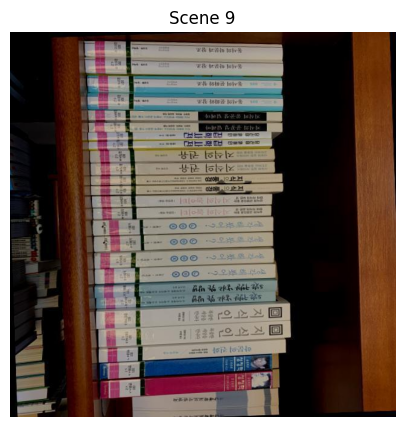



Scene 10:


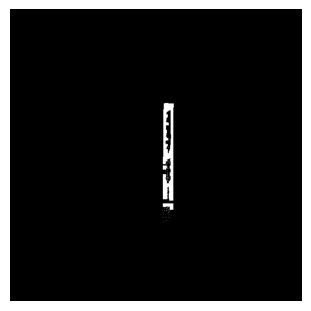

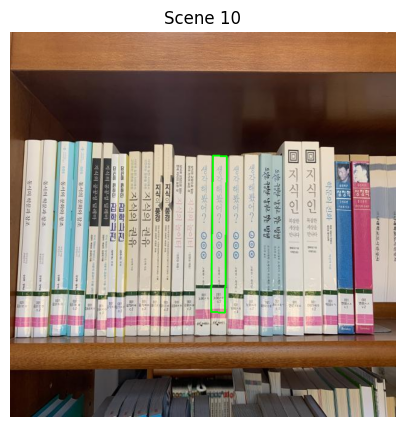

Model 19: 1 instance(s)

Scene 11:


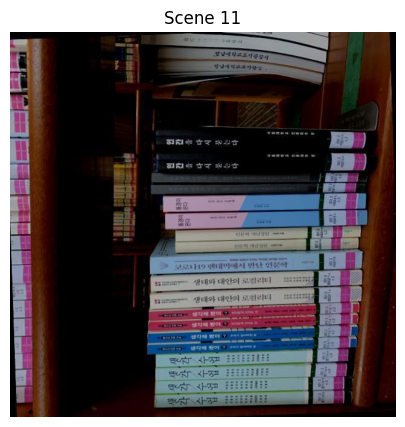



Scene 12:


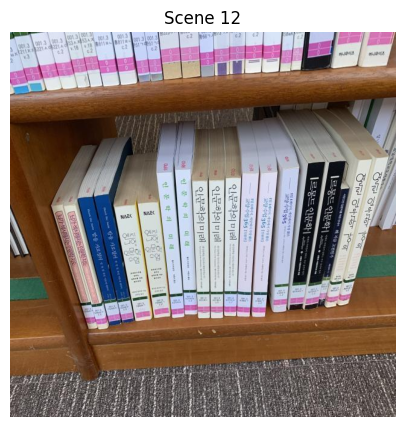



Scene 13:


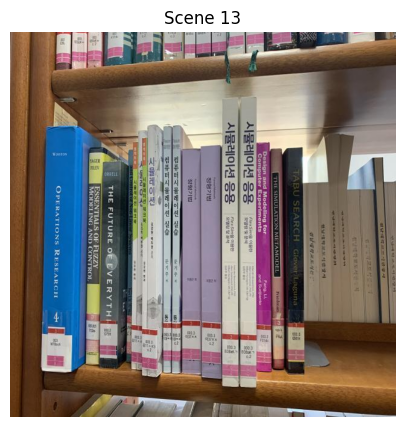



Scene 14:


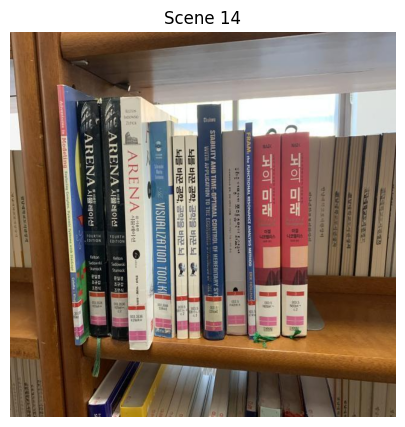



Scene 15:


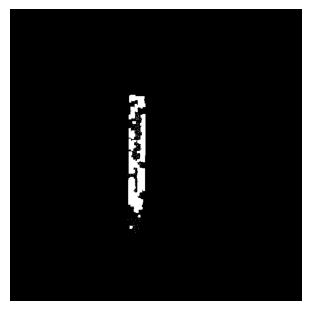

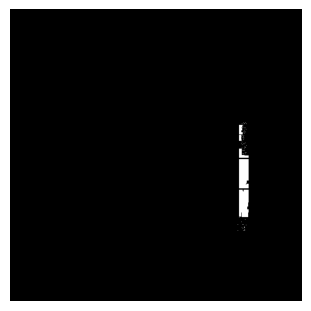

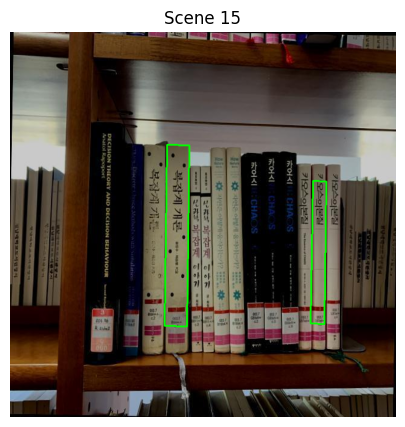

Model 11: 1 instance(s) | Model 12: 1 instance(s)

Scene 16:


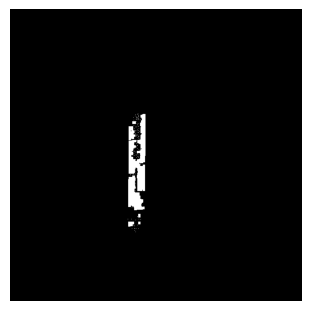

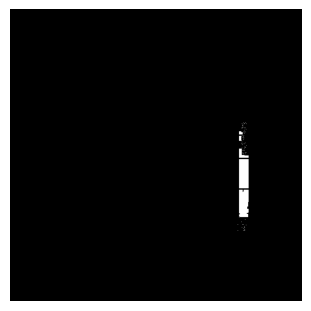

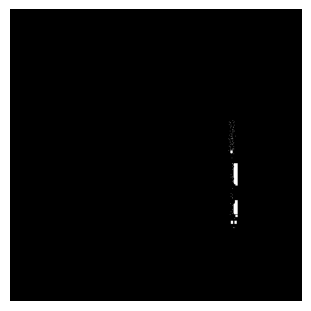

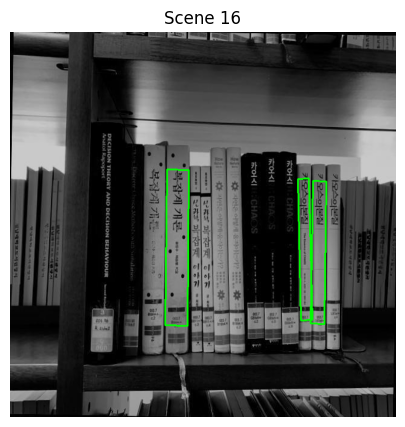

Model 11: 1 instance(s) | Model 12: 2 instance(s)

Scene 17:


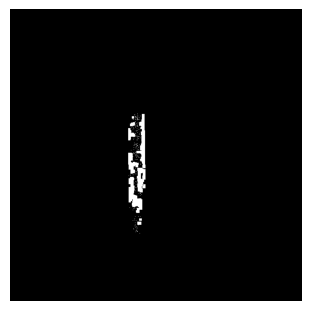

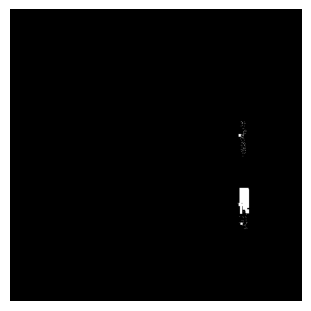

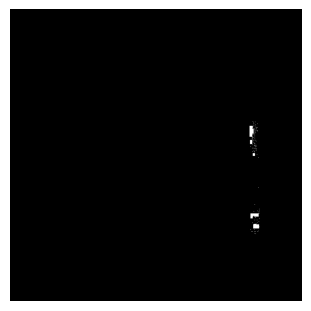

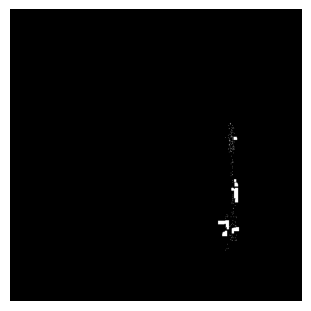

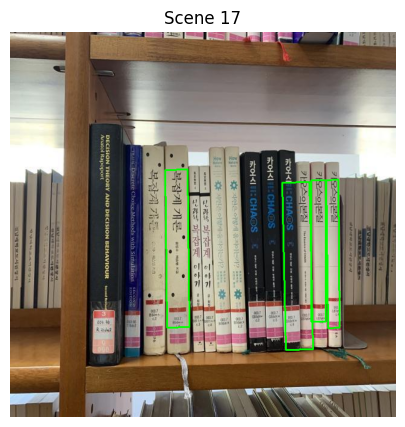

Model 11: 1 instance(s) | Model 12: 3 instance(s)

Scene 18:


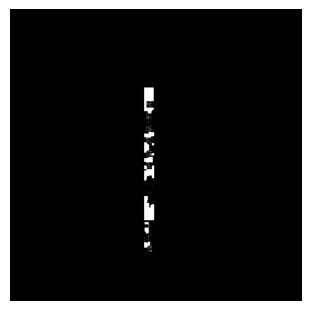

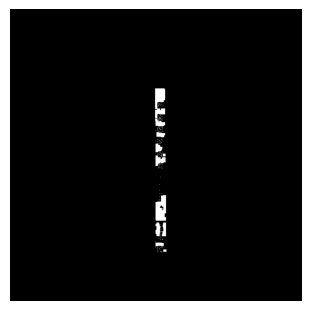

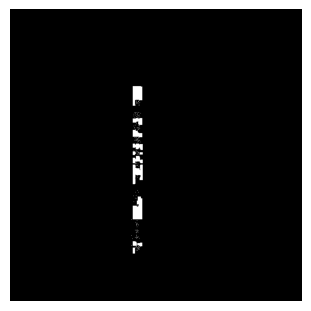

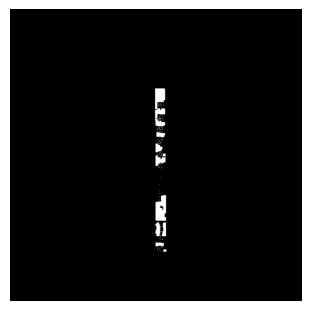

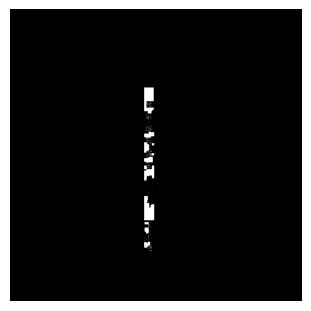

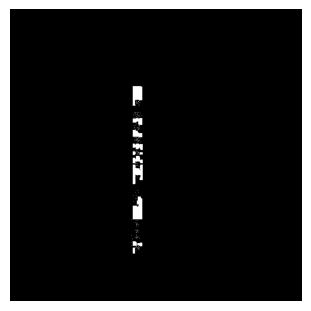

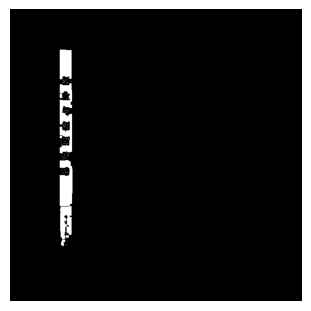

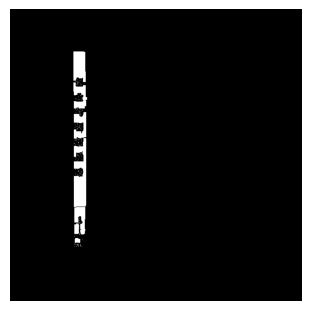

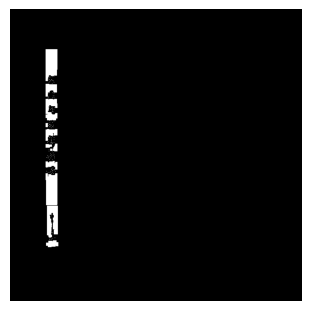

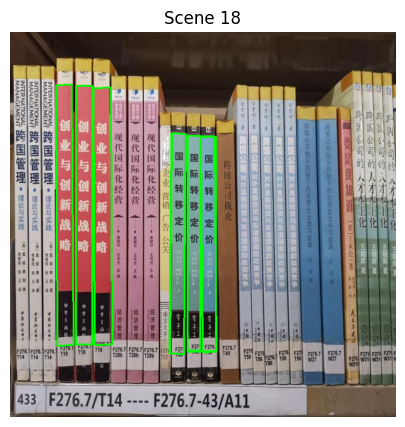

Model 8: 3 instance(s) | Model 9: 3 instance(s) | Model 10: 3 instance(s)

Scene 19:


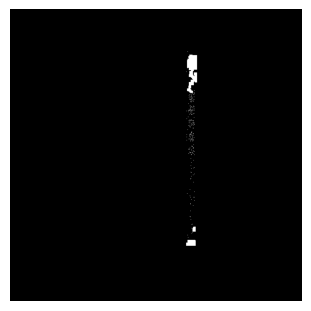

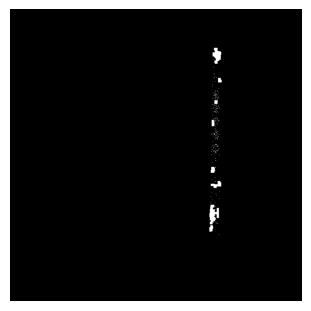

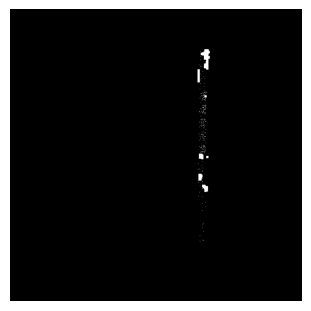

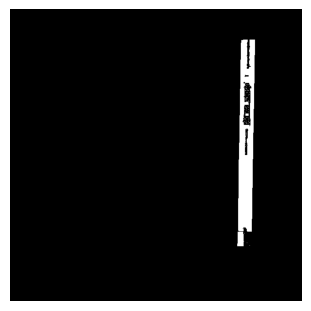

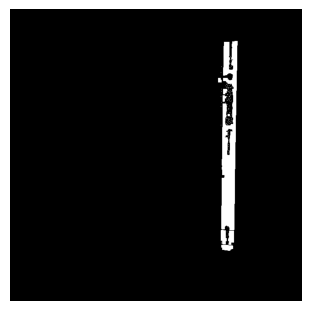

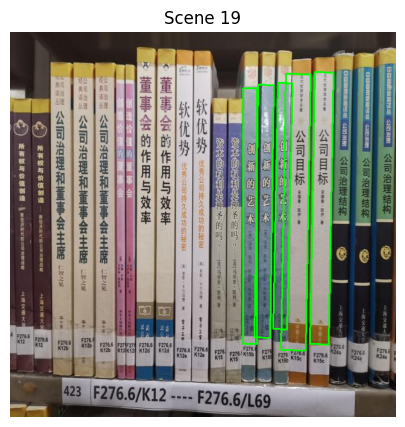

Model 6: 3 instance(s) | Model 7: 2 instance(s)

Scene 20:


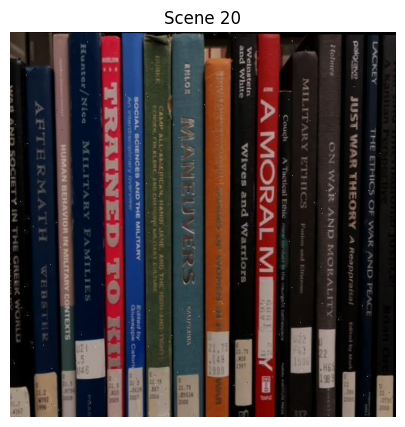



Scene 21:


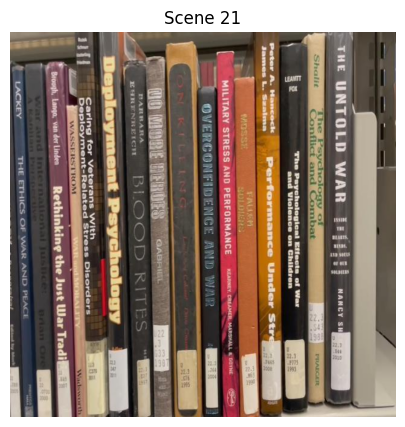



Scene 22:


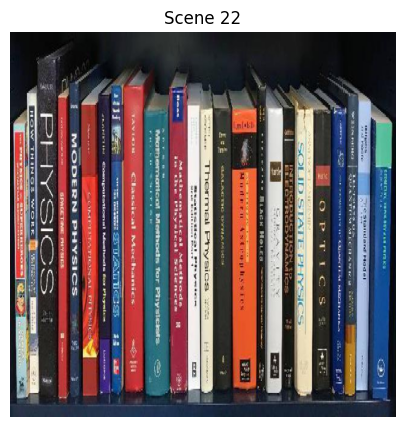



Scene 23:


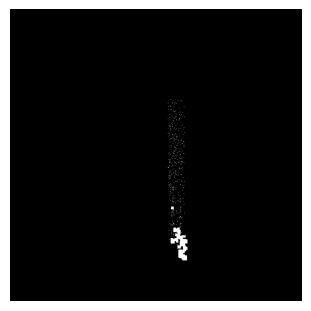

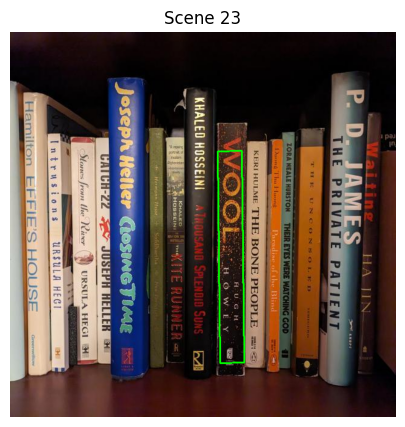

Model 5: 1 instance(s)

Scene 24:


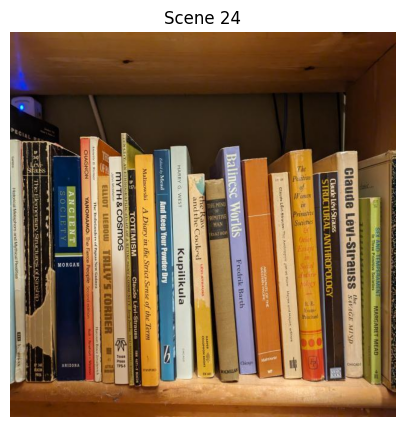



Scene 25:


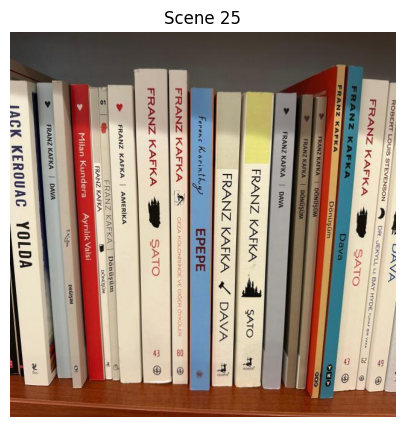



Scene 26:


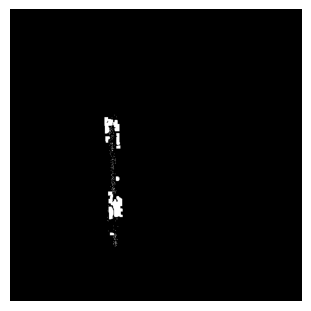

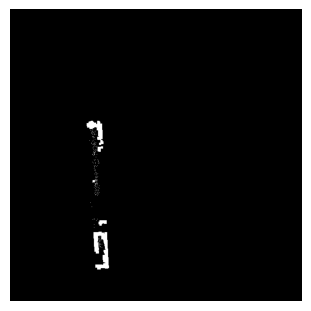

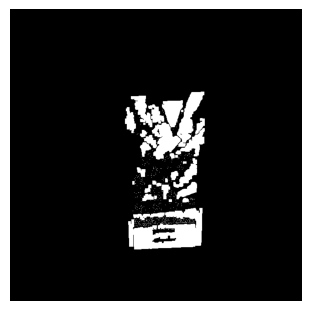

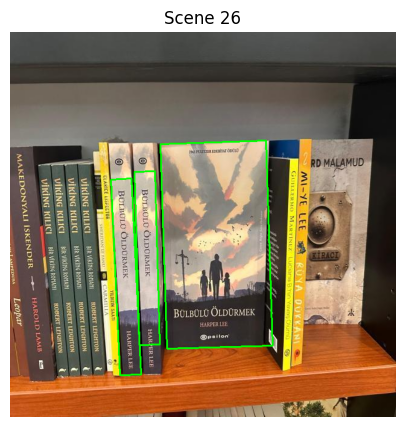

Model 0: 2 instance(s) | Model 4: 1 instance(s)

Scene 27:


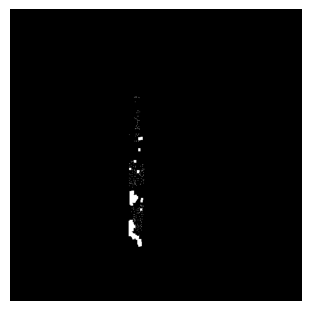

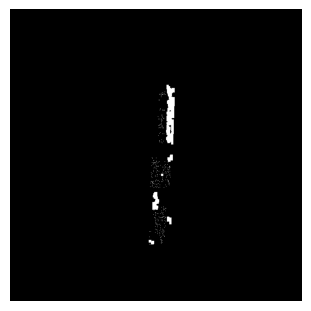

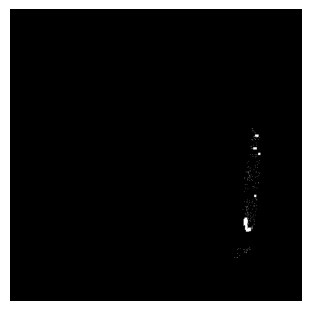

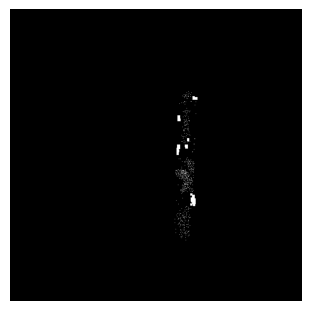

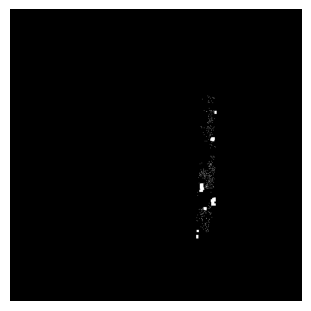

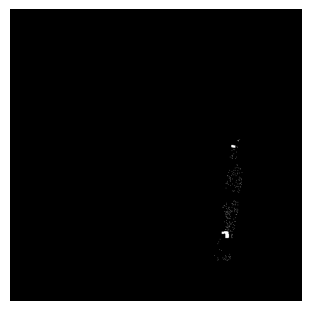

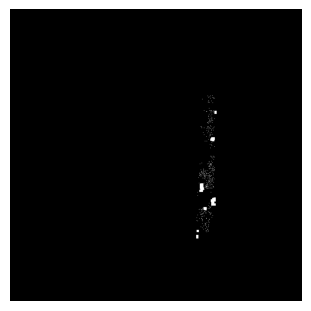

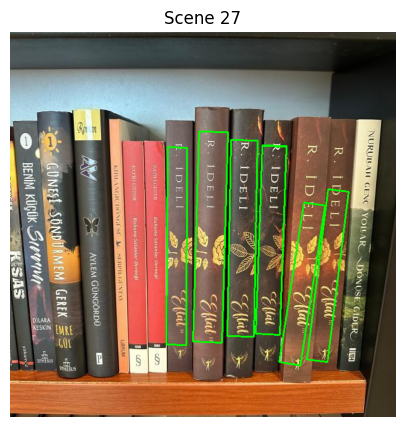

Model 2: 6 instance(s) | Model 3: 1 instance(s)

Scene 28:


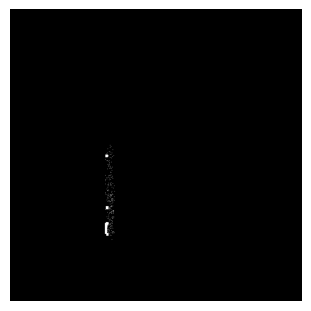

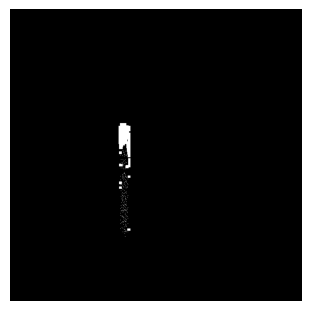

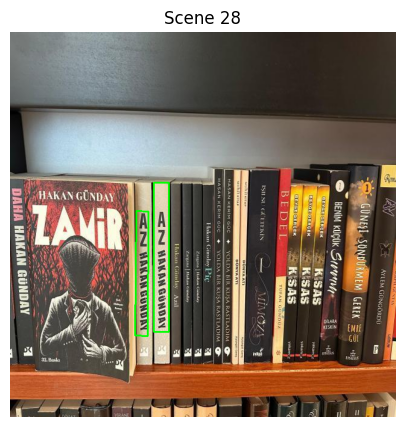

Model 1: 2 instance(s)


In [248]:
results = alternative_experiment(params=params2, max_instances=10)